In [9]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
import seaborn
seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk') # or paper

In [38]:
import os
METRICS_FOLDER = '/sdf/group/neutrino/ldomine/chain/me/mpvmpr_012022/log_metrics1/'

## UResNet

In [3]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         xlabel='Predicted label',
                         ylabel='True label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    xticklabels = ['Shower', 'Track', 'Michel', 'Delta', 'LowE']
    if cm.shape[1] > 5:
        xticklabels.append('Ghost')
    #     if cm.shape[1] > 5:
    #         xticklabels.append('Ghost')
        
    fig, ax = plt.subplots()
    print(cm.shape)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #labels = ['HIP', 'MIP', 'Shower', 'Delta', 'Michel']
    labels = ['Shower', 'Track', 'Michel', 'Delta', 'LowE']
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=xticklabels, yticklabels=labels,
           title=title,
           ylabel=ylabel,
           xlabel=xlabel,
           ylim=(-0.5, cm.shape[0]-0.5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
from numpy.linalg import norm
range = __builtins__.range
def confusion_matrix(metrics, num_classes):
    x = np.zeros((num_classes, num_classes+1))
    for c in range(num_classes):
        for c2 in range(num_classes):
            x[c][c2] = np.nansum(metrics['confusion_%d_%d' % (c, c2)])
        x[c][-1] = np.nansum(metrics['num_true_pix_class%d' % c]-metrics['num_true_deghost_pix_class%d' % c])
    return x / x.sum(axis=1, keepdims=True)

In [15]:
deghosting = pd.read_csv(os.path.join(METRICS_FOLDER, 'deghosting_metrics.csv'))

In [12]:
seaborn.set(style="white", font_scale=2.5)
plot_confusion_matrix(np.array(confusion_matrix(deghosting, 5)*100))

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')

NameError: name 'confusion_matrix' is not defined

In [13]:
print('Fraction of ghost2ghost = %.2f %%'  % (100*deghosting['ghost2ghost'].mean()))
print('Fraction of nonghost2nonghost = %.2f %%' % (100*deghosting['nonghost2nonghost'].mean()))

Fraction of ghost2ghost = 88.70 %
Fraction of nonghost2nonghost = 92.37 %


## PPN

In [17]:
logs_gt = pd.read_csv(os.path.join(METRICS_FOLDER, "ppn-metrics-gt.csv"))
logs_pred = pd.read_csv(os.path.join(METRICS_FOLDER, "ppn-metrics-pred.csv"))

In [22]:
#label = 'distance_to_closest_pred_point'
distance_to_closest_pred = 'min_distance'
point_type = 'Class'
distance = 3 # px
#print('Fraction of true points that are not in attention layer = ', np.count_nonzero(logs_gt['attention']==0)/len(logs_gt))
# print('Fraction of Track true points with no predicted point within %dpx = ' % distance, np.count_nonzero((logs_gt[point_type] == 0) & (logs_gt[distance_to_closest_pred] > distance)) / np.count_nonzero(logs_gt[point_type] == 0))
# print('Fraction of Shower true points with no predicted point within %dpx = ' % distance, np.count_nonzero((logs_gt[point_type] == 1) & (logs_gt[distance_to_closest_pred] > distance)) / np.count_nonzero(logs_gt[point_type] == 1))
print('Fraction of true points with no predicted point within %dpx = ' % distance, np.count_nonzero((logs_gt[distance_to_closest_pred] > distance)) / logs_gt.shape[0])

Fraction of true points with no predicted point within 3px =  0.28161713156720697


Median of pred. points within 3px of true point =  0.566303
Median of pred. points within 5px of true point =  0.631132


Text(0, 0.5, 'Points')

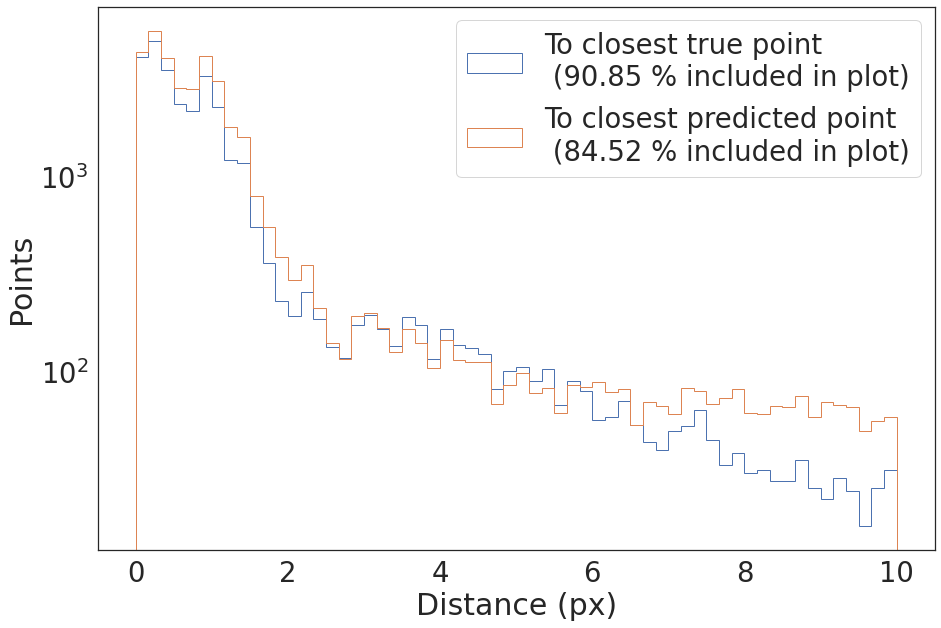

In [26]:
no_delta_pred = logs_pred['score_type_3'] < 0.5

#print("After removing delta points, keeping:", np.count_nonzero(no_delta_pred)/no_delta_pred.shape[0])

r = [0, 10]
bins = 60 #25
f= plt.figure()

fraction1 = np.count_nonzero(logs_pred[no_delta_pred]['min_distance']<r[1])/len(logs_pred[no_delta_pred])
plt.hist(logs_pred[no_delta_pred]['min_distance'], range=r, bins=bins, histtype='step', label='To closest true point \n (%.2f %% included in plot)' % (fraction1*100))

#print("Fraction of predicted points included in plot = ", fraction1)
print("Median of pred. points within 3px of true point = ", np.median(logs_pred[no_delta_pred]['min_distance'][logs_pred[no_delta_pred]['min_distance']<3]))
print("Median of pred. points within 5px of true point = ", np.median(logs_pred[no_delta_pred]['min_distance'][logs_pred[no_delta_pred]['min_distance']<5]))

no_delta_gt = logs_gt['Class'] != 3
fraction2 =  np.count_nonzero(logs_gt[no_delta_gt]['min_distance']<r[1])/len(logs_gt[no_delta_gt])
plt.hist(logs_gt[no_delta_gt]['min_distance'], range=r, bins=bins, histtype='step', label='To closest predicted point \n (%.2f %% included in plot)' % (fraction2*100))

plt.legend()
plt.yscale('log')
plt.xlabel('Distance (px)')
plt.ylabel('Points')
#print("Fraction of true points included in plot = ", fraction2)

## GraphSpice

In [27]:
graph_spice = pd.read_csv(os.path.join(METRICS_FOLDER, "graph-spice-metrics.csv"))

0.9891107078039928


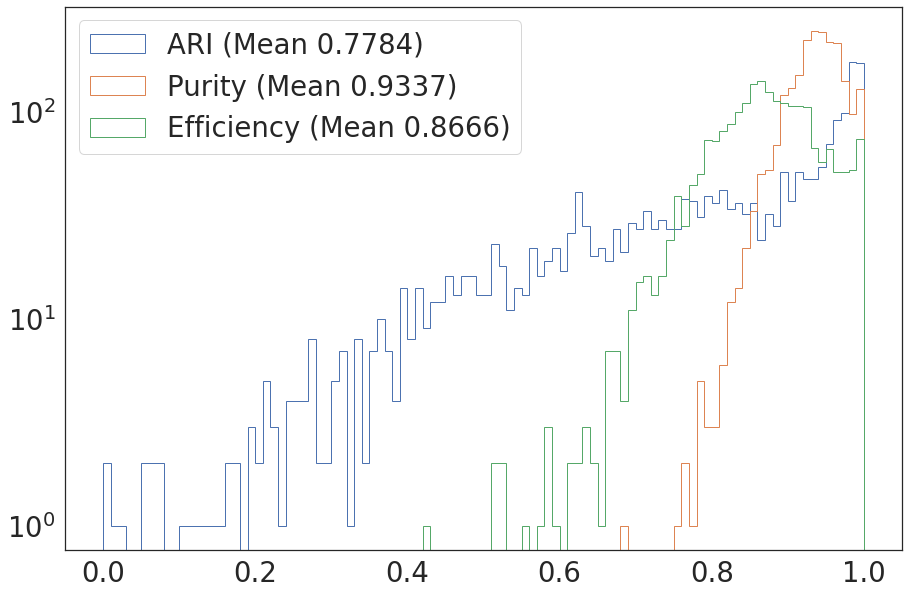

In [28]:
nonzero_ari = graph_spice['ARI'] > 0
print(np.count_nonzero(nonzero_ari)/len(graph_spice))
plt.hist(graph_spice['ARI'][nonzero_ari], range=[0, 1], bins=100, label='ARI (Mean %.4f)' % graph_spice['ARI'][nonzero_ari].mean(), histtype='step')
plt.hist(graph_spice['purity'][nonzero_ari], range=[0, 1], bins=100, label='Purity (Mean %.4f)' % graph_spice['purity'][nonzero_ari].mean(), histtype='step')
plt.hist(graph_spice['efficiency'][nonzero_ari], range=[0, 1], bins=100, label='Efficiency (Mean %.4f)' % graph_spice['efficiency'][nonzero_ari].mean(), histtype='step')
plt.legend(loc='upper left')
plt.yscale('log')

## Shower Grappa clustering

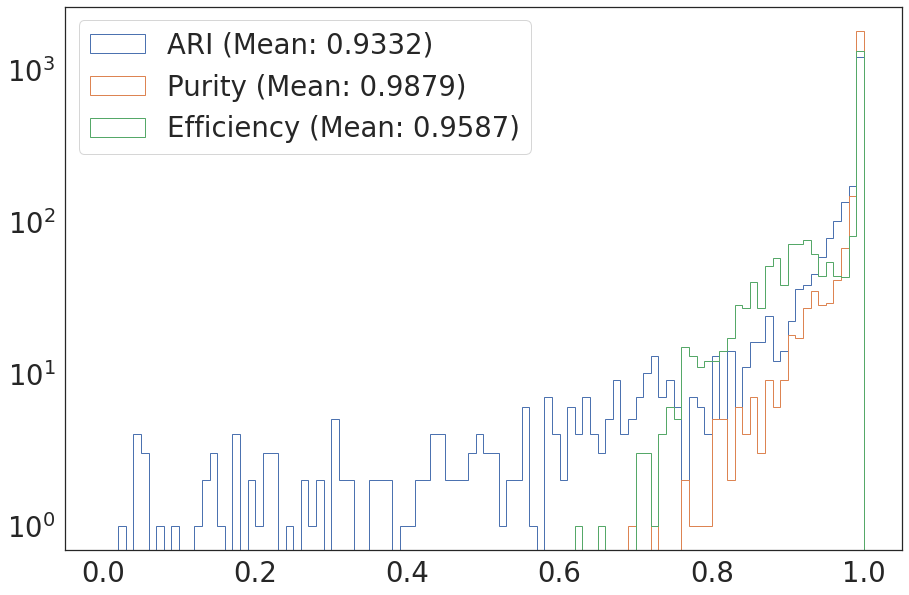

In [29]:
logs = pd.read_csv(os.path.join(METRICS_FOLDER, "cluster-gnn-metrics-shower.csv"))
plt.hist(logs['ari'][logs['ari']>0], label="ARI (Mean: %.4f)" % logs['ari'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
plt.hist(logs['pur'][logs['ari']>0], label="Purity (Mean: %.4f)" % logs['pur'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
plt.hist(logs['eff'][logs['ari']>0], label="Efficiency (Mean: %.4f)" % logs['eff'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
plt.legend(loc='upper left')
plt.yscale('log')

## Track Grappa clustering

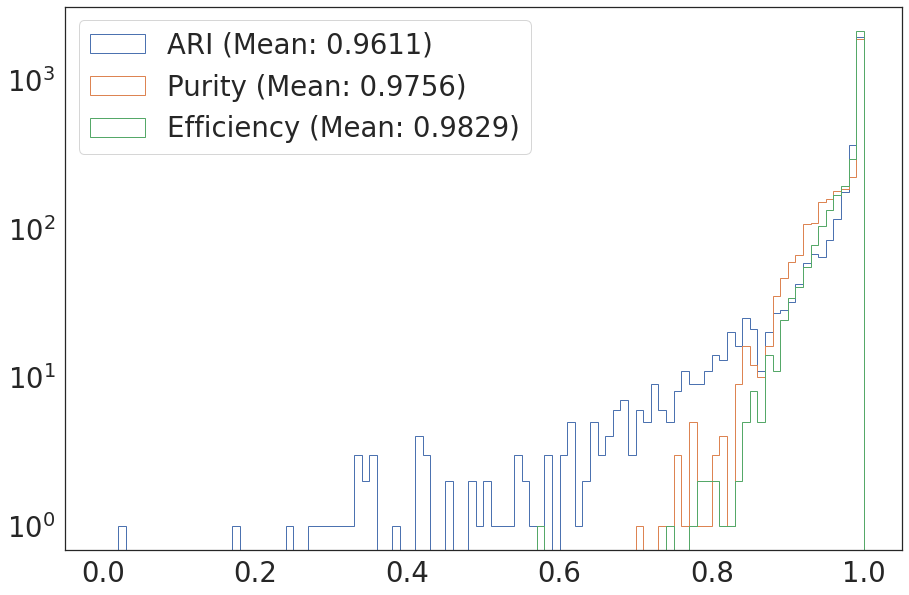

In [32]:
logs = pd.read_csv(os.path.join(METRICS_FOLDER, "cluster-gnn-metrics-track.csv"))
plt.hist(logs['ari'][logs['ari']>0], label="ARI (Mean: %.4f)" % logs['ari'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
plt.hist(logs['pur'][logs['ari']>0], label="Purity (Mean: %.4f)" % logs['pur'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
plt.hist(logs['eff'][logs['ari']>0], label="Efficiency (Mean: %.4f)" % logs['eff'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
plt.legend(loc='upper left')
plt.yscale('log')

## Interaction Grappa clustering

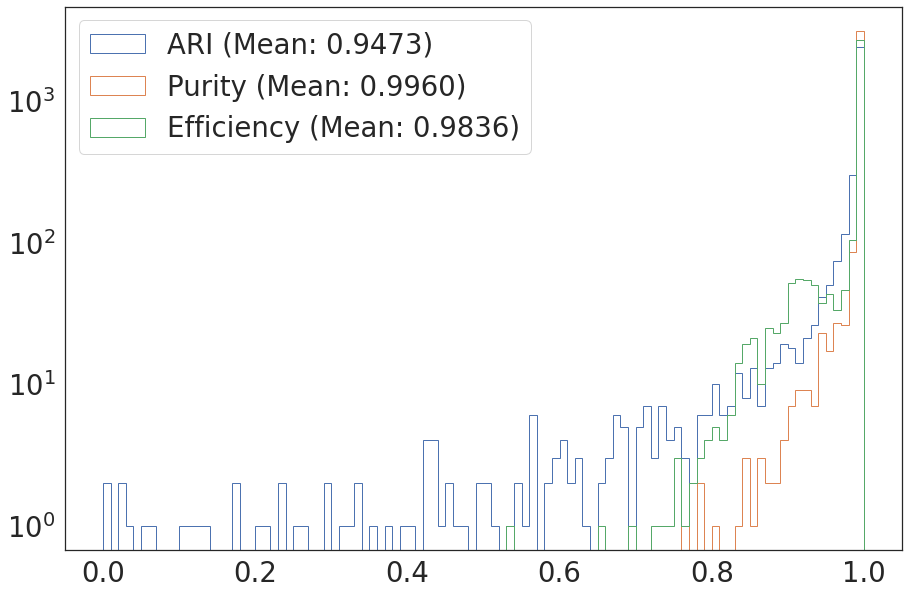

In [35]:
logs = pd.read_csv(os.path.join(METRICS_FOLDER, "cluster-gnn-metrics-inter.csv"))
plt.hist(logs['ari'][logs['ari']>0], label="ARI (Mean: %.4f)" % logs['ari'].mean(), histtype='step', range=[0, 1], bins=100)
plt.hist(logs['pur'][logs['ari']>0], label="Purity (Mean: %.4f)" % logs['pur'].mean(), histtype='step', range=[0, 1], bins=100)
plt.hist(logs['eff'][logs['ari']>0], label="Efficiency (Mean: %.4f)" % logs['eff'].mean(), histtype='step', range=[0, 1], bins=100)
plt.legend(loc='upper left')
plt.yscale('log')

## PID

In [40]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         xlabel='Predicted label',
                         ylabel='True label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #xticklabels = ['HIP', 'MIP', 'Shower', 'Delta', 'Michel']
    
    xticklabels = ['Photon', '$e$', '$\mu$', '$\pi$', 'Proton']
    if cm.shape[1] > 5:
        xticklabels.append('Ghost')
    #     if cm.shape[1] > 5:
    #         xticklabels.append('Ghost')
        
    fig, ax = plt.subplots()
    print(cm.shape)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #labels = ['HIP', 'MIP', 'Shower', 'Delta', 'Michel']
    labels = ['Photon', '$e$', '$\mu$', '$\pi$', 'Proton']
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=xticklabels, yticklabels=labels,
           title=title,
           ylabel=ylabel,
           xlabel=xlabel,
           ylim=(-0.5, cm.shape[0]-0.5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [41]:
from numpy.linalg import norm
def confusion_matrix(kinematics, num_classes):
    x = np.zeros((num_classes, num_classes))
    for c in range(num_classes):
        for c2 in range(num_classes):
            x[c][c2] =  np.count_nonzero((kinematics['true_type'] == c) & (kinematics['pred_type'] == c2) )
        #x[c][-1] = np.nansum(metrics['num_true_pix_class%d' % c]-metrics['num_true_deghost_pix_class%d' % c])
    return x / x.sum(axis=1, keepdims=True)

In [50]:
kinematics = pd.read_csv(os.path.join(METRICS_FOLDER, "pid-metrics.csv"))

(5, 5)


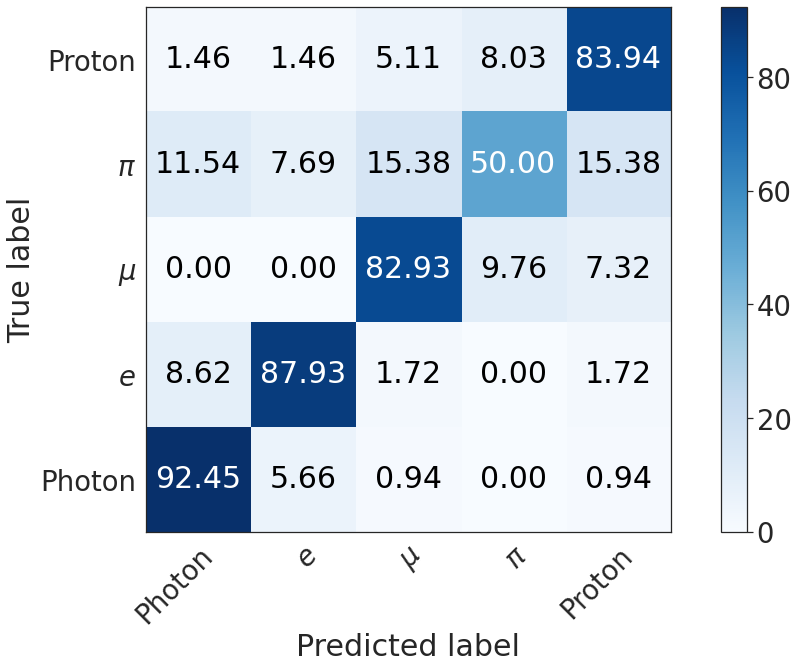

In [52]:
seaborn.set(style="white", font_scale=2.5)
plot_confusion_matrix(np.array(confusion_matrix(kinematics, 5)*100))
#plt.savefig("confusion_matrix.png", transparent=True)
seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')